In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyreadr
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import glob
import scanpy as sc
from scipy.stats.stats import pearsonr
from venn import venn

# functions

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, title=''):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.title = title
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1], self.title)
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs, title=None):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)
        if title is not None:
            ax.set_title(title)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [3]:
def plot_volcano(df):
    sns.scatterplot(
    x='log2FCFROZEN',
    y=-np.log10(df['FDR'].values),
    hue='category',
    data=df,
    s=10,
    marker='o',
    edgecolor='b',
    linewidth=0.05,
    palette=['green', 'red', 'orange', 'black'],
    hue_order=['FDR < 1e-5 & |log2FC| > 1', 'FDR < 1e-5', '|log2FC| > 1', 'None'])

In [4]:
def corr_plot(combined, x, y):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x,
                    y=y,
                    data=combined,
                    s=3,
                    alpha=0.3,
                    linewidth=0)
    a = np.max([combined[x],combined[y]])
    plt.plot([0, a], [0, a], color='red', linewidth=1)
    corr = pearsonr(combined[x], combined[y])[0]
    plt.text(0, np.max(combined[y]), f"Pearson correlation: {corr:.4f}")
    plt.text(0, np.max(combined[y]) - 0.2, r"$R^2$: " + f"{corr**2:.4f}")

# No Filtering

In [207]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
#     sc.pp.filter_genes(data, min_counts=50)
#     sc.pp.normalize_total(data)
    data_dict[f] = data
    gene_list = data.var_names

In [212]:
combined = {}
for sample in sorted(data_dict):
    sample_name = '_'.join(sample.split('_')[:3])
    combined[sample_name] = np.log10(np.sum(data_dict[sample].X.toarray(), axis=1) + 1)

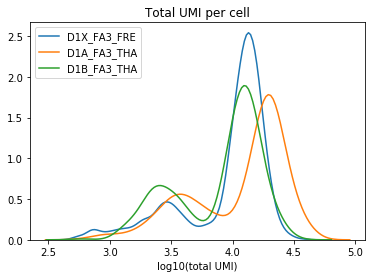

In [229]:
sns.distplot(combined['D1X_FA3_FRE'], hist=False, label='D1X_FA3_FRE')
sns.distplot(combined['D1A_FA3_THA'], hist=False, label='D1A_FA3_THA')
sns.distplot(combined['D1B_FA3_THA'], hist=False, label='D1B_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

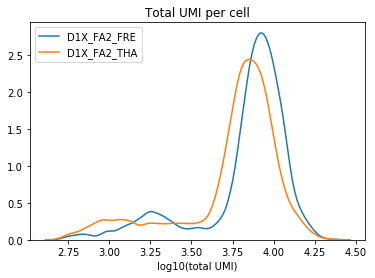

In [226]:
sns.distplot(combined['D1X_FA2_FRE'], hist=False, label='D1X_FA2_FRE')
sns.distplot(combined['D1X_FA2_THA'], hist=False, label='D1X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

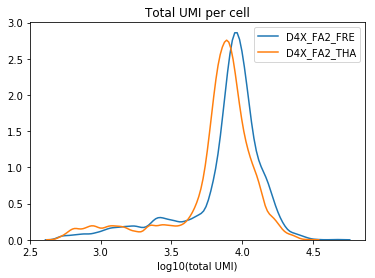

In [227]:
sns.distplot(combined['D4X_FA2_FRE'], hist=False, label='D4X_FA2_FRE')
sns.distplot(combined['D4X_FA2_THA'], hist=False, label='D4X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

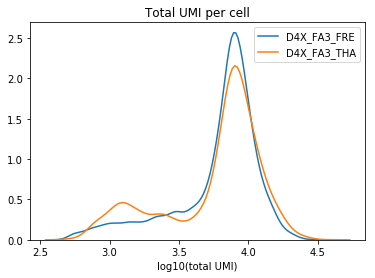

In [228]:
sns.distplot(combined['D4X_FA3_FRE'], hist=False, label='D4X_FA3_FRE')
sns.distplot(combined['D4X_FA3_THA'], hist=False, label='D4X_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

# Filtering

In [230]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
    sc.pp.filter_cells(data, min_counts=4000)
    sc.pp.filter_cells(data, max_counts=40000)
#     sc.pp.filter_genes(data, min_counts=50)
#     sc.pp.normalize_total(data)
    data_dict[f] = data
    gene_list = data.var_names

In [231]:
combined = {}
for sample in sorted(data_dict):
    sample_name = '_'.join(sample.split('_')[:3])
    combined[sample_name] = np.log10(np.sum(data_dict[sample].X.toarray(), axis=1) + 1)

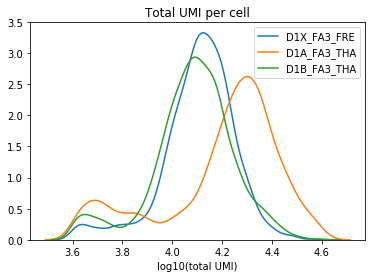

In [232]:
sns.distplot(combined['D1X_FA3_FRE'], hist=False, label='D1X_FA3_FRE')
sns.distplot(combined['D1A_FA3_THA'], hist=False, label='D1A_FA3_THA')
sns.distplot(combined['D1B_FA3_THA'], hist=False, label='D1B_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

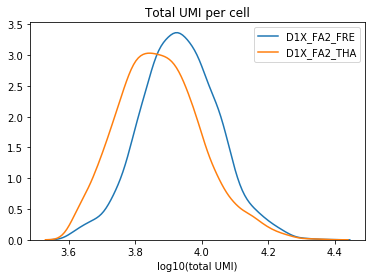

In [233]:
sns.distplot(combined['D1X_FA2_FRE'], hist=False, label='D1X_FA2_FRE')
sns.distplot(combined['D1X_FA2_THA'], hist=False, label='D1X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

# Preliminary DEG

In [402]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
    f = f[:11]
    sc.pp.filter_cells(data, min_counts=4000)
    sc.pp.filter_cells(data, max_counts=40000)
#     sc.pp.filter_genes(data, min_counts=50)
#     sc.pp.normalize_total(data)
    data.obs['sample'] = f
    data_dict[f] = data
    gene_list = data.var_names

## D1 FA3

In [403]:
combined_adata = data_dict['D1A_FA3_THA'].concatenate(
    data_dict['D1B_FA3_THA'], data_dict['D1X_FA3_FRE'])
sc.pp.normalize_total(combined_adata)

combined = pd.DataFrame(index=gene_list)
combined.index.name = 'gene'
for sample in ['D1A_FA3_THA', 'D1B_FA3_THA', 'D1X_FA3_FRE']:
    combined[sample] = np.log10(
        np.mean(combined_adata[combined_adata.obs['sample'] ==
                               sample, :].X.toarray(),
                axis=0) + 1)

Text(0.5, 1.0, 'D1A_FA3_THA vs D1B_FA3_THA')

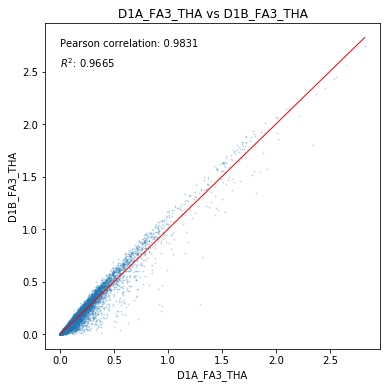

In [404]:
corr_plot(combined, 'D1A_FA3_THA', 'D1B_FA3_THA')
plt.title('D1A_FA3_THA vs D1B_FA3_THA')

Text(0.5, 1.0, 'D1X_FA3_FRE vs D1A_FA3_THA')

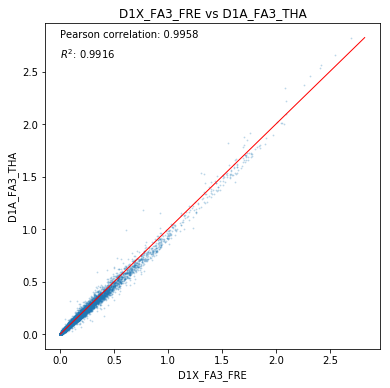

In [307]:
corr_plot(combined, 'D1X_FA3_FRE', 'D1A_FA3_THA')
plt.title('D1X_FA3_FRE vs D1A_FA3_THA')

Text(0.5, 1.0, 'D1X_FA3_FRE vs D1B_FA3_THA')

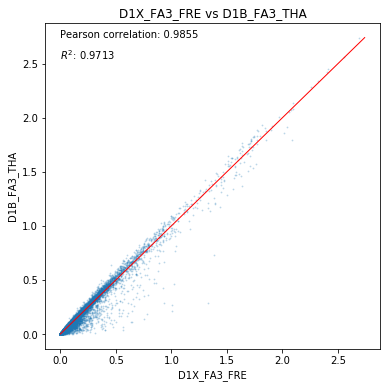

In [308]:
corr_plot(combined, 'D1X_FA3_FRE', 'D1B_FA3_THA')
plt.title('D1X_FA3_FRE vs D1B_FA3_THA')

## D1 FA2

In [309]:
combined_adata = data_dict['D1X_FA2_FRE'].concatenate(data_dict['D1X_FA2_THA'])
sc.pp.normalize_total(combined_adata)

combined = pd.DataFrame(index=gene_list)
combined.index.name = 'gene'
for sample in ['D1X_FA2_FRE', 'D1X_FA2_THA']:
    combined[sample] = np.log10(
        np.mean(combined_adata[combined_adata.obs['sample'] ==
                               sample, :].X.toarray(),
                axis=0) + 1)

Text(0.5, 1.0, 'D1X_FA2_FRE vs D1X_FA2_THA')

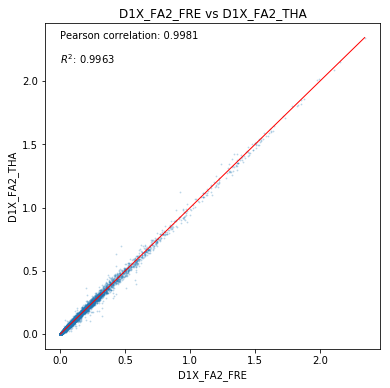

In [310]:
corr_plot(combined, 'D1X_FA2_FRE', 'D1X_FA2_THA')
plt.title('D1X_FA2_FRE vs D1X_FA2_THA')

## D4 FA2

In [311]:
combined_adata = data_dict['D4X_FA2_FRE'].concatenate(data_dict['D4X_FA2_THA'])
sc.pp.normalize_total(combined_adata)

combined = pd.DataFrame(index=gene_list)
combined.index.name = 'gene'
for sample in ['D4X_FA2_FRE', 'D4X_FA2_THA']:
    combined[sample] = np.log10(
        np.mean(combined_adata[combined_adata.obs['sample'] ==
                               sample, :].X.toarray(),
                axis=0) + 1)

Text(0.5, 1.0, 'D4X_FA2_FRE vs D4X_FA2_THA')

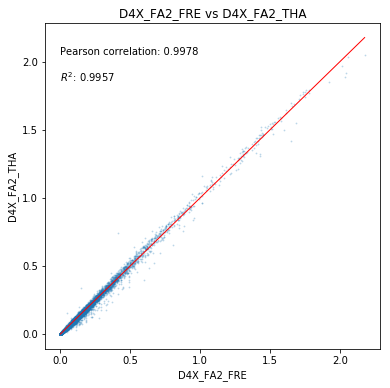

In [312]:
corr_plot(combined, 'D4X_FA2_FRE', 'D4X_FA2_THA')
plt.title('D4X_FA2_FRE vs D4X_FA2_THA')

## D4 FA3

In [313]:
combined_adata = data_dict['D4X_FA3_FRE'].concatenate(data_dict['D4X_FA3_THA'])
sc.pp.normalize_total(combined_adata)

combined = pd.DataFrame(index=gene_list)
combined.index.name = 'gene'
for sample in ['D4X_FA3_FRE', 'D4X_FA3_THA']:
    combined[sample] = np.log10(
        np.mean(combined_adata[combined_adata.obs['sample'] ==
                               sample, :].X.toarray(),
                axis=0) + 1)

Text(0.5, 1.0, 'D4X_FA3_FRE vs D4X_FA3_THA')

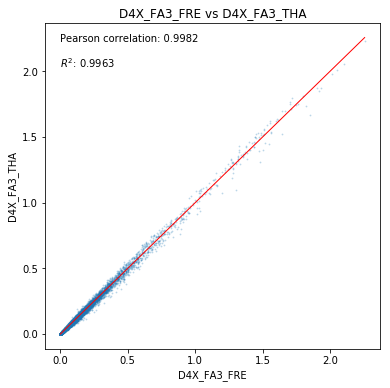

In [314]:
corr_plot(combined, 'D4X_FA3_FRE', 'D4X_FA3_THA')
plt.title('D4X_FA3_FRE vs D4X_FA3_THA')

# NBID

In [73]:
FDR_threshold = 1e-3

In [74]:
deg_dfs = []
deg_min500_dfs = []
deg_all_dfs = []
deg_all_min500_dfs = []

## D1

### FA2

#### all genes

In [75]:
D1_FA2_nocontrol = pd.read_csv("../data/deg/D1_FA2_nocontrol.tsv", sep="\t")
print(D1_FA2_nocontrol.shape)
D1_FA2_nocontrol = D1_FA2_nocontrol[D1_FA2_nocontrol['FDR'] < FDR_threshold]

D1_FA2_nocontrol = D1_FA2_nocontrol[~((D1_FA2_nocontrol.index.str.startswith('RPS')) |
                  (D1_FA2_nocontrol.index.str.startswith('RPL')) |
                  (D1_FA2_nocontrol.index.str.startswith('MT')))]
D1_FA2_nocontrol['category'] = D1_FA2_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(23139, 7)


In [76]:
print(D1_FA2_nocontrol[D1_FA2_nocontrol['log2FCFROZEN'] < 0].shape)
print(D1_FA2_nocontrol[D1_FA2_nocontrol['log2FCFROZEN'] > 0].shape)

(563, 8)
(900, 8)


In [77]:
D1_FA2_nocontrol[D1_FA2_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
GLRX5,6.677825e-316,1.154384e-319,1461.022339,-1.011049,0.003284,0.058561,-1.458636,FDR < 1e-5 & |log2FC| > 1
BRI3,2.503303e-183,1.406411e-186,848.681955,-0.940507,0.017875,0.049665,-1.356864,FDR < 1e-5 & |log2FC| > 1
BLOC1S4,5.903293e-88,7.398569e-91,408.598732,-0.958156,0.005625,0.051538,-1.382328,FDR < 1e-5 & |log2FC| > 1
PLPPR3,1.577071e-83,2.044692e-86,388.195929,-1.314518,0.183897,0.000005,-1.896448,FDR < 1e-5 & |log2FC| > 1
PPP1R35,3.427715e-76,5.184754e-79,354.189977,-0.784102,0.042526,0.169078,-1.131221,FDR < 1e-5 & |log2FC| > 1
FOSB,1.475801e-57,3.252771e-60,267.901597,3.136977,0.000069,1.047387,4.525702,FDR < 1e-5 & |log2FC| > 1
SAC3D1,6.558309e-55,1.558870e-57,255.603817,-0.726173,0.026131,0.092729,-1.047646,FDR < 1e-5 & |log2FC| > 1
JUN,4.801403e-52,1.245016e-54,242.291001,1.181434,6.324794,2.037743,1.704449,FDR < 1e-5 & |log2FC| > 1
EID2,2.951349e-34,1.198958e-36,159.884866,-0.728820,0.170058,0.165198,-1.051464,FDR < 1e-5 & |log2FC| > 1
CHPT1,4.027560e-34,1.670970e-36,159.225047,-0.850175,0.000030,0.000012,-1.226544,FDR < 1e-5 & |log2FC| > 1


In [78]:
D1_FA2_nocontrol[D1_FA2_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
UTF1,0.000011,4.293754e-07,25.557582,-0.840434,1.644365,1.677200,-1.212490,|log2FC| > 1
AC245014.3,0.000011,4.496924e-07,25.468382,0.830740,0.000014,1.312403,1.198505,|log2FC| > 1
ANKRD1,0.000029,1.288972e-06,23.439607,3.190147,0.000352,1298.669396,4.602410,|log2FC| > 1
AGFG2,0.000029,1.303537e-06,23.417991,0.701472,0.000010,3.243787,1.012011,|log2FC| > 1
AL133338.1,0.000036,1.664745e-06,22.947639,-0.817555,0.000039,0.000019,-1.179483,|log2FC| > 1
IGFBPL1,0.000043,1.998340e-06,22.596638,-0.988814,0.000005,0.000020,-1.426557,|log2FC| > 1
LINC00324,0.000068,3.348379e-06,21.605799,1.070419,13.124658,1.648474,1.544288,|log2FC| > 1
IGFBP5,0.000076,3.795148e-06,21.365626,-21.900436,1905.533502,0.096188,-31.595650,|log2FC| > 1
AC008764.6,0.000090,4.556415e-06,21.015253,-0.743780,2.003278,5.080316,-1.073047,|log2FC| > 1
MZF1-AS1,0.000111,5.776629e-06,20.560822,1.035133,13.311869,3.231811,1.493381,|log2FC| > 1


In [79]:
tmp = D1_FA2_nocontrol[D1_FA2_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'], axis=1)
df = pd.DataFrame({
    'gene': tmp.index.values,
    'FDR': tmp['FDR'],
    'log2FCFROZEN': tmp['log2FCFROZEN']
})
df['sample'] = 'D1_FA2'
deg_dfs.append(df)
D1_FA2_nocontrol['sample'] = 'D1_FA2'
deg_all_dfs.append(D1_FA2_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


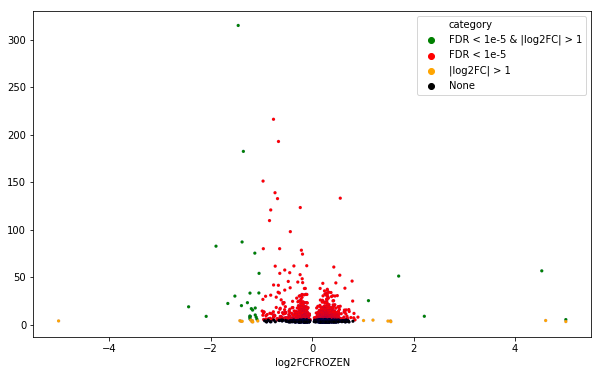

In [80]:
D1_FA2_nocontrol.loc[D1_FA2_nocontrol['log2FCFROZEN']>5, 'log2FCFROZEN'] = 5
D1_FA2_nocontrol.loc[D1_FA2_nocontrol['log2FCFROZEN']<-5, 'log2FCFROZEN'] = -5

plt.figure(figsize=(10, 6))
plot_volcano(D1_FA2_nocontrol)

#### min 500

In [81]:
D1_FA2_nocontrol = pd.read_csv("../data/deg/D1_FA2_min500_nocontrol.tsv", sep="\t")
print(D1_FA2_nocontrol.shape)

D1_FA2_nocontrol = D1_FA2_nocontrol[D1_FA2_nocontrol['FDR'] < FDR_threshold]

D1_FA2_nocontrol = D1_FA2_nocontrol[~((D1_FA2_nocontrol.index.str.startswith('RPS')) |
                  (D1_FA2_nocontrol.index.str.startswith('RPL')) |
                  (D1_FA2_nocontrol.index.str.startswith('MT')))]
D1_FA2_nocontrol['category'] = D1_FA2_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(6955, 7)


In [82]:
print(D1_FA2_nocontrol[D1_FA2_nocontrol['log2FCFROZEN'] < 0].shape)
print(D1_FA2_nocontrol[D1_FA2_nocontrol['log2FCFROZEN'] > 0].shape)

(524, 8)
(989, 8)


In [83]:
D1_FA2_nocontrol[D1_FA2_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
GLRX5,6.723493e-316,3.866854e-319,1458.606230,-1.010206,0.003250,0.058485,-1.457419,FDR < 1e-5 & |log2FC| > 1
BRI3,1.708309e-183,3.193100e-186,847.043980,-0.939659,0.018014,0.049947,-1.355641,FDR < 1e-5 & |log2FC| > 1
BLOC1S4,2.541146e-88,1.059572e-90,407.882152,-0.957312,0.005349,0.051600,-1.381109,FDR < 1e-5 & |log2FC| > 1
PLPPR3,6.167501e-84,2.660317e-86,387.670880,-1.313673,0.184131,0.000009,-1.895230,FDR < 1e-5 & |log2FC| > 1
PPP1R35,1.499932e-76,7.763849e-79,353.384728,-0.783251,0.042539,0.169780,-1.129992,FDR < 1e-5 & |log2FC| > 1
SAC3D1,2.786172e-55,2.123179e-57,254.988303,-0.725329,0.026514,0.092880,-1.046429,FDR < 1e-5 & |log2FC| > 1
JUN,1.154088e-52,9.624310e-55,242.803785,1.182394,6.318504,2.036373,1.705835,FDR < 1e-5 & |log2FC| > 1
EID2,1.092988e-34,1.445792e-36,159.512758,-0.727963,0.169588,0.165433,-1.050229,FDR < 1e-5 & |log2FC| > 1
CHPT1,1.437033e-34,1.962877e-36,158.905021,-0.849332,0.000031,0.000016,-1.225327,FDR < 1e-5 & |log2FC| > 1
AL355075.4,9.505922e-27,1.831479e-28,122.459146,0.769651,0.816061,1.103925,1.110372,FDR < 1e-5 & |log2FC| > 1


In [84]:
D1_FA2_nocontrol[D1_FA2_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category


In [85]:
tmp = D1_FA2_nocontrol[D1_FA2_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'],axis=1)
df = pd.DataFrame({'gene':tmp.index.values,'FDR':tmp['FDR'],'log2FCFROZEN':tmp['log2FCFROZEN']})
df['sample'] = 'D1_FA2'
deg_min500_dfs.append(df)
D1_FA2_nocontrol['sample'] = 'D1_FA2'
deg_all_min500_dfs.append(D1_FA2_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


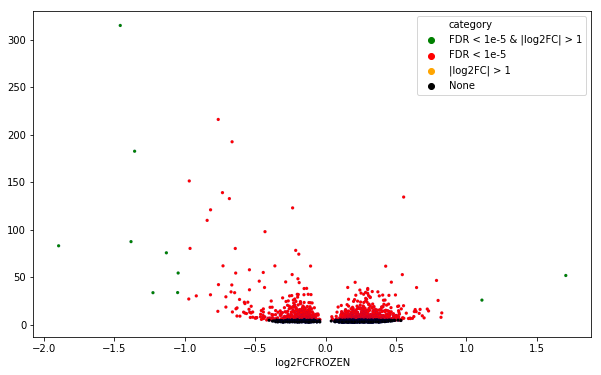

In [86]:
plt.figure(figsize=(10, 6))
plot_volcano(D1_FA2_nocontrol)

### FA3

#### all genes

In [87]:
D1_FA3_nocontrol = pd.read_csv("../data/deg/D1_FA3_nocontrol.tsv", sep="\t")
print(D1_FA3_nocontrol.shape)

D1_FA3_nocontrol = D1_FA3_nocontrol[D1_FA3_nocontrol['FDR'] < FDR_threshold]

D1_FA3_nocontrol = D1_FA3_nocontrol[~((D1_FA3_nocontrol.index.str.startswith('RPS')) |
                  (D1_FA3_nocontrol.index.str.startswith('RPL')) |
                  (D1_FA3_nocontrol.index.str.startswith('MT')))]
D1_FA3_nocontrol['category'] = D1_FA3_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(23609, 7)


In [88]:
print(D1_FA3_nocontrol[D1_FA3_nocontrol['log2FCFROZEN'] < 0].shape)
print(D1_FA3_nocontrol[D1_FA3_nocontrol['log2FCFROZEN'] > 0].shape)

(1120, 8)
(1107, 8)


In [89]:
D1_FA3_nocontrol[D1_FA3_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'],axis=1)

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN
GLRX5,0.000000e+00,0.000000e+00,1490.081713,-1.111132,0.000004,0.038383,-1.603024
POU5F1B,6.886162e-177,7.583557e-180,817.718130,-1.004405,0.012020,0.000004,-1.449050
IFITM1,4.810000e-168,6.315812e-171,776.688800,0.964441,0.000009,0.093177,1.391394
BRI3,1.584616e-124,3.490196e-127,575.546335,-0.866547,0.038058,0.065925,-1.250163
BLOC1S4,2.215544e-109,5.818278e-112,505.575835,-1.075287,0.000009,0.024455,-1.551311
PLCG2,1.186994e-99,3.619958e-102,460.566076,1.374680,0.000012,0.202425,1.983244
PLPPR3,3.485127e-84,1.210472e-86,389.241726,-1.477704,0.000003,0.000014,-2.131876
PPP1R35,3.615082e-63,1.975287e-65,291.840051,-0.703253,0.064269,0.029166,-1.014579
UTF1,1.150379e-60,6.870410e-63,280.177194,-1.098593,0.865165,1.314420,-1.584934
FOSB,5.129156e-31,6.604529e-33,142.768526,2.023305,0.000017,1.060008,2.919013


In [90]:
D1_FA3_nocontrol[D1_FA3_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
AC099568.2,0.000011,6.906701e-07,24.640987,-1.849164,0.000009,0.000156,-2.667779,|log2FC| > 1
IQCH-AS1,0.000012,7.503589e-07,24.481266,0.822987,0.000009,0.408370,1.187319,|log2FC| > 1
FAM71D,0.000015,9.712815e-07,23.984227,-0.969238,0.000222,0.000002,-1.398315,|log2FC| > 1
MROH8,0.000016,1.064675e-06,23.807487,1.190476,28.562743,54.365897,1.717493,|log2FC| > 1
LINC01355,0.000029,1.972811e-06,22.621341,0.775197,0.000011,0.941319,1.118373,|log2FC| > 1
CU634019.6,0.000048,3.466292e-06,21.539423,0.725792,0.000036,0.000003,1.047096,|log2FC| > 1
ZBTB20-AS5,0.000052,3.788039e-06,21.369221,19.692155,52.287811,5.990847,28.409774,|log2FC| > 1
LINC01411,0.000062,4.630258e-06,20.984452,19.315847,0.085420,677.848264,27.866876,|log2FC| > 1
AC103591.3,0.000071,5.343791e-06,20.709939,0.713368,2.226705,0.462927,1.029172,|log2FC| > 1
AC008555.5,0.000104,8.048357e-06,19.926345,0.837460,0.000024,0.000003,1.208200,|log2FC| > 1


In [91]:
tmp = D1_FA3_nocontrol[D1_FA3_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'], axis=1)
df = pd.DataFrame({
    'gene': tmp.index.values,
    'FDR': tmp['FDR'],
    'log2FCFROZEN': tmp['log2FCFROZEN']
})
df['sample'] = 'D1_FA3'
deg_dfs.append(df)
D1_FA3_nocontrol['sample'] = 'D1_FA3'
deg_all_dfs.append(D1_FA3_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


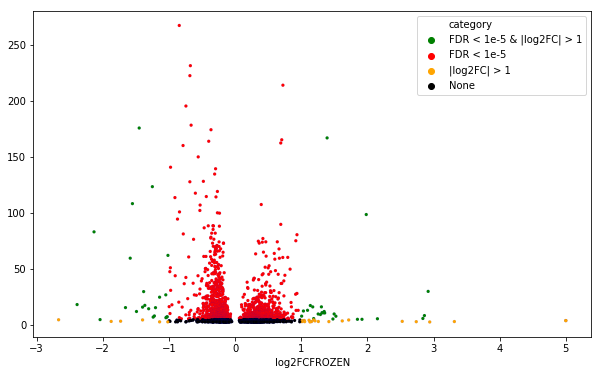

In [92]:
D1_FA3_nocontrol.loc[D1_FA3_nocontrol['log2FCFROZEN']>5, 'log2FCFROZEN'] = 5
D1_FA3_nocontrol.loc[D1_FA3_nocontrol['log2FCFROZEN']<-5, 'log2FCFROZEN'] = -5
plt.figure(figsize=(10, 6))
plot_volcano(D1_FA3_nocontrol)

#### min500

In [93]:
D1_FA3_nocontrol = pd.read_csv("../data/deg/D1_FA3_min500_nocontrol.tsv", sep="\t")
print(D1_FA3_nocontrol.shape)
D1_FA3_nocontrol = D1_FA3_nocontrol[D1_FA3_nocontrol['FDR'] < FDR_threshold]

D1_FA3_nocontrol = D1_FA3_nocontrol[~((D1_FA3_nocontrol.index.str.startswith('RPS')) |
                  (D1_FA3_nocontrol.index.str.startswith('RPL')) |
                  (D1_FA3_nocontrol.index.str.startswith('MT')))]
D1_FA3_nocontrol['category'] = D1_FA3_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(7511, 7)


In [94]:
print(D1_FA3_nocontrol[D1_FA3_nocontrol['log2FCFROZEN'] < 0].shape)
print(D1_FA3_nocontrol[D1_FA3_nocontrol['log2FCFROZEN'] > 0].shape)

(1123, 8)
(1147, 8)


In [95]:
D1_FA3_nocontrol[D1_FA3_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'],axis=1)

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN
GLRX5,0.000000e+00,0.000000e+00,1485.131001,-1.109435,0.000007,0.038865,-1.600576
POU5F1B,8.685094e-177,3.006423e-179,814.966784,-1.002706,0.011977,0.000007,-1.446599
IFITM1,3.515746e-169,1.451047e-171,779.626576,0.966116,0.000015,0.093056,1.393810
BRI3,1.564124e-124,1.103696e-126,573.247740,-0.864838,0.037839,0.066397,-1.247697
BLOC1S4,1.566924e-109,1.314288e-111,503.949292,-1.073594,0.000005,0.024768,-1.548869
PLCG2,2.105380e-100,1.934113e-102,461.817002,1.376405,0.000015,0.203361,1.985733
PLPPR3,1.757838e-84,1.919088e-86,388.322400,-1.476005,0.000004,0.000020,-2.129425
PPP1R35,2.343765e-63,4.025373e-65,290.421084,-0.701554,0.064154,0.029611,-1.012129
UTF1,5.901346e-61,1.099971e-62,279.239232,-1.096860,0.865615,1.316022,-1.582434
FGF8,2.682381e-28,1.164234e-29,127.927423,-0.724209,0.607688,0.595649,-1.044812


In [96]:
D1_FA3_nocontrol[D1_FA3_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category


In [97]:
tmp = D1_FA3_nocontrol[D1_FA3_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'], axis=1)
df = pd.DataFrame({
    'gene': tmp.index.values,
    'FDR': tmp['FDR'],
    'log2FCFROZEN': tmp['log2FCFROZEN']
})
df['sample'] = 'D1_FA3'
deg_min500_dfs.append(df)
D1_FA3_nocontrol['sample'] = 'D1_FA3'
deg_all_min500_dfs.append(D1_FA3_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


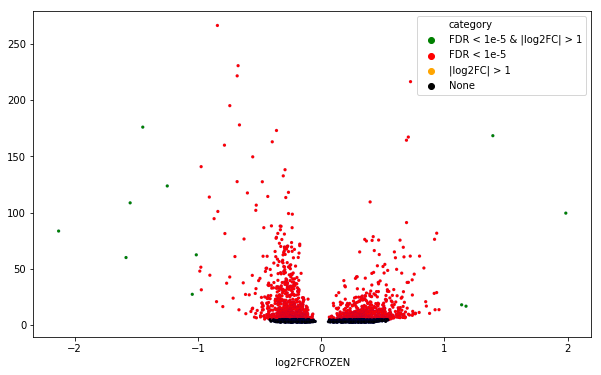

In [98]:
plt.figure(figsize=(10, 6))
plot_volcano(D1_FA3_nocontrol)

## D4

### FA2

#### all genes

In [99]:
D4_FA2_nocontrol = pd.read_csv("../data/deg/D4_FA2_nocontrol.tsv", sep="\t")
print(D4_FA2_nocontrol.shape)
D4_FA2_nocontrol = D4_FA2_nocontrol[D4_FA2_nocontrol['FDR'] < FDR_threshold]

D4_FA2_nocontrol = D4_FA2_nocontrol[~((D4_FA2_nocontrol.index.str.startswith('RPS')) |
                  (D4_FA2_nocontrol.index.str.startswith('RPL')) |
                  (D4_FA2_nocontrol.index.str.startswith('MT')))]
D4_FA2_nocontrol['category'] = D4_FA2_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(22535, 7)


In [100]:
print(D4_FA2_nocontrol[D4_FA2_nocontrol['log2FCFROZEN'] < 0].shape)
print(D4_FA2_nocontrol[D4_FA2_nocontrol['log2FCFROZEN'] > 0].shape)

(635, 8)
(665, 8)


In [101]:
D4_FA2_nocontrol[D4_FA2_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'], axis=1)

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN
TAF10,7.655772e-255,4.076737e-258,1177.798635,-1.048138,0.036096,0.097824,-1.512143
CENPV,4.684000e-208,3.949235e-211,961.621587,-0.831510,0.112946,0.225487,-1.199616
ACBD3,1.675163e-111,2.676098e-114,516.318520,-0.730695,0.043298,0.051518,-1.054170
EBPL,1.226951e-110,2.068965e-113,512.235881,-0.719007,0.000013,0.000004,-1.037308
HES4,1.221555e-109,2.168280e-112,507.546100,-1.371517,1.574115,0.800334,-1.978681
PGP,3.371957e-104,6.284543e-107,482.442455,-0.814160,0.091251,0.131015,-1.174585
GLRX5,4.878790e-97,1.060842e-99,449.230177,-0.868536,0.020683,0.136583,-1.253032
CTNNBIP1,1.110676e-84,2.907915e-87,392.086798,-0.720326,0.024401,0.111117,-1.039211
SLC25A33,2.137801e-69,6.356009e-72,321.642259,-0.763907,0.000007,0.000007,-1.102085
PPP1R35,2.803800e-64,8.958223e-67,298.005907,-0.875569,0.242920,0.000004,-1.263179


In [102]:
D4_FA2_nocontrol[D4_FA2_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
DUBR,0.000045,0.000002,22.589655,0.864645,0.000008,1.792507,1.247419,|log2FC| > 1
MFSD14A,0.000070,0.000003,21.693728,-0.748691,0.275291,0.841852,-1.080133,|log2FC| > 1
CD37,0.000083,0.000004,21.302774,-1.153208,1.481138,0.000031,-1.663728,|log2FC| > 1
NRL,0.000104,0.000005,20.825319,-1.082247,5.787180,0.000034,-1.561352,|log2FC| > 1
SLC10A4,0.000153,0.000008,20.014755,-1.165730,0.000006,0.000042,-1.681793,|log2FC| > 1
SH2B2,0.000171,0.000009,19.784517,-2.029094,10.375356,0.000155,-2.927364,|log2FC| > 1
MZF1-AS1,0.000310,0.000017,18.546112,1.092289,0.000026,1.264504,1.575840,|log2FC| > 1
KCNK15,0.000605,0.000035,17.137907,-1.019129,0.000005,0.000007,-1.470292,|log2FC| > 1
NTRK1,0.000925,0.000056,16.227441,1.242635,0.000143,0.000013,1.792743,|log2FC| > 1


In [103]:
tmp = D4_FA2_nocontrol[D4_FA2_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'], axis=1)
df = pd.DataFrame({
    'gene': tmp.index.values,
    'FDR': tmp['FDR'],
    'log2FCFROZEN': tmp['log2FCFROZEN']
})
df['sample'] = 'D4_FA2'
deg_dfs.append(df)
D4_FA2_nocontrol['sample'] = 'D4_FA2'
deg_all_dfs.append(D4_FA2_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


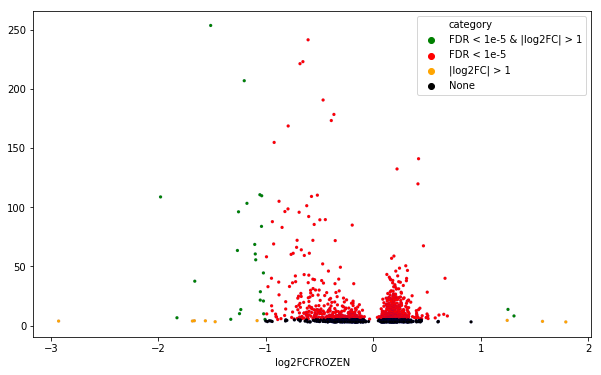

In [104]:
plt.figure(figsize=(10, 6))
plot_volcano(D4_FA2_nocontrol)

#### min counts = 500

In [105]:
D4_FA2_nocontrol = pd.read_csv("../data/deg/D4_FA2_min500_nocontrol.tsv", sep="\t")
print(D4_FA2_nocontrol.shape)
D4_FA2_nocontrol = D4_FA2_nocontrol[D4_FA2_nocontrol['FDR'] < FDR_threshold]

D4_FA2_nocontrol = D4_FA2_nocontrol[~((D4_FA2_nocontrol.index.str.startswith('RPS')) |
                  (D4_FA2_nocontrol.index.str.startswith('RPL')) |
                  (D4_FA2_nocontrol.index.str.startswith('MT')))]
D4_FA2_nocontrol['category'] = D4_FA2_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(7393, 7)


In [106]:
print(D4_FA2_nocontrol[D4_FA2_nocontrol['log2FCFROZEN'] < 0].shape)
print(D4_FA2_nocontrol[D4_FA2_nocontrol['log2FCFROZEN'] > 0].shape)

(621, 8)
(737, 8)


In [107]:
D4_FA2_nocontrol[D4_FA2_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])].drop(['category'],axis=1)

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN
TAF10,8.393166e-256,1.362343e-258,1179.988962,-1.049086,0.036056,0.097794,-1.513511
CENPV,5.494521e-209,1.412091e-211,963.676358,-0.832449,0.112825,0.226023,-1.200970
ACBD3,2.830752e-112,1.378426e-114,517.642803,-0.731642,0.043277,0.051687,-1.055536
EBPL,2.047320e-111,1.052322e-113,513.585359,-0.719951,0.000007,0.000005,-1.038670
HES4,2.758198e-110,1.492329e-112,508.291830,-1.372420,1.572816,0.800089,-1.979984
PGP,6.304972e-105,3.581886e-107,483.564549,-0.815109,0.091187,0.131190,-1.175954
GLRX5,1.066685e-97,6.781305e-100,450.123157,-0.869471,0.020673,0.137878,-1.254381
CTNNBIP1,2.192397e-85,1.749647e-87,393.100275,-0.721266,0.024276,0.111488,-1.040568
SLC25A33,4.702920e-70,4.262081e-72,322.439086,-0.764850,0.000027,0.000008,-1.103445
PPP1R35,6.657429e-65,6.483632e-67,298.650343,-0.876545,0.243469,0.000007,-1.264587


In [108]:
D4_FA2_nocontrol[D4_FA2_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category


In [109]:
tmp = D4_FA2_nocontrol[D4_FA2_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]
df = pd.DataFrame({'gene':tmp.index.values,'FDR':tmp['FDR'],'log2FCFROZEN':tmp['log2FCFROZEN']})
df['sample'] = 'D4_FA2'
deg_min500_dfs.append(df)
D4_FA2_nocontrol['sample'] = 'D4_FA2'

deg_all_min500_dfs.append(D4_FA2_nocontrol)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


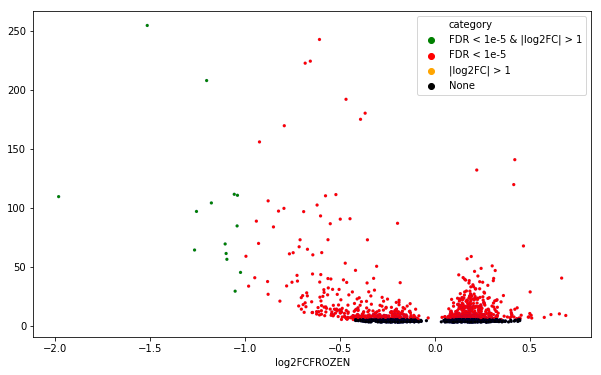

In [110]:
plt.figure(figsize=(10, 6))
plot_volcano(D4_FA2_nocontrol)

### FA3

#### all genes

In [111]:
D4_FA3_nocontrol = pd.read_csv("../data/deg/D4_FA3_nocontrol.tsv", sep="\t")
print(D4_FA3_nocontrol.shape)
D4_FA3_nocontrol = D4_FA3_nocontrol[D4_FA3_nocontrol['FDR'] < FDR_threshold]

D4_FA3_nocontrol = D4_FA3_nocontrol[~((D4_FA3_nocontrol.index.str.startswith('RPS')) |
                  (D4_FA3_nocontrol.index.str.startswith('RPL')) |
                  (D4_FA3_nocontrol.index.str.startswith('MT')))]
D4_FA3_nocontrol['category'] = D4_FA3_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(22455, 7)


In [112]:
print(D4_FA3_nocontrol[D4_FA3_nocontrol['log2FCFROZEN'] < 0].shape)
print(D4_FA3_nocontrol[D4_FA3_nocontrol['log2FCFROZEN'] > 0].shape)

(428, 8)
(539, 8)


In [113]:
D4_FA3_nocontrol[D4_FA3_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
NME2,6.213619e-20,4.759485e-22,93.186366,-0.750149,0.000003,0.000130,-1.082236,FDR < 1e-5 & |log2FC| > 1
AC008264.2,1.313316e-08,2.427192e-10,40.088455,-0.930270,0.847448,0.392103,-1.342096,FDR < 1e-5 & |log2FC| > 1
PAM16,3.993757e-07,9.141800e-09,33.015693,-0.720744,0.634787,0.000005,-1.039814,FDR < 1e-5 & |log2FC| > 1
SORBS2,3.462148e-06,9.096714e-08,28.557280,-0.735014,0.000012,1.934840,-1.060402,FDR < 1e-5 & |log2FC| > 1
FAM71D,1.630731e-05,4.872947e-07,25.313467,-1.225331,0.000012,0.000047,-1.767779,|log2FC| > 1
AC008443.5,3.981937e-04,1.654486e-05,18.550653,-0.796886,0.732095,2.311316,-1.149663,|log2FC| > 1
ABHD16A,7.173670e-04,3.229829e-05,17.277535,-0.972537,0.000005,0.000020,-1.403075,|log2FC| > 1


In [114]:
D4_FA3_nocontrol[D4_FA3_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category
FAM71D,0.000016,4.872947e-07,25.313467,-1.225331,0.000012,0.000047,-1.767779,|log2FC| > 1
AC008443.5,0.000398,1.654486e-05,18.550653,-0.796886,0.732095,2.311316,-1.149663,|log2FC| > 1
ABHD16A,0.000717,3.229829e-05,17.277535,-0.972537,0.000005,0.000020,-1.403075,|log2FC| > 1


In [115]:
tmp = D4_FA3_nocontrol[D4_FA3_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]
df = pd.DataFrame({
    'gene': tmp.index.values,
    'FDR': tmp['FDR'],
    'log2FCFROZEN': tmp['log2FCFROZEN']
})
df['sample'] = 'D4_FA3'
deg_dfs.append(df)
D4_FA3_nocontrol['sample'] = 'D4_FA3'

deg_all_dfs.append(D4_FA3_nocontrol)

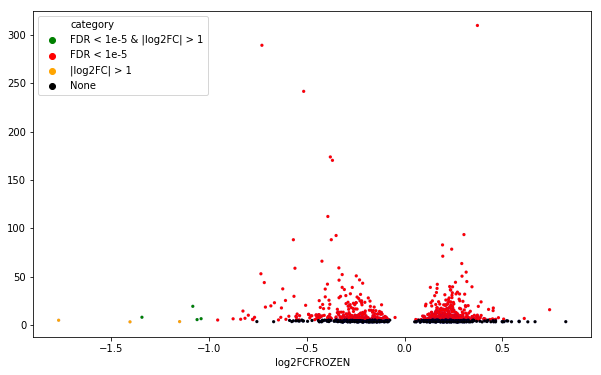

In [116]:
plt.figure(figsize=(10, 6))
plot_volcano(D4_FA3_nocontrol)

#### min 500

In [117]:
D4_FA3_nocontrol = pd.read_csv("../data/deg/D4_FA3_min500_nocontrol.tsv", sep="\t")
print(D4_FA3_nocontrol.shape)
D4_FA3_nocontrol = D4_FA3_nocontrol[D4_FA3_nocontrol['FDR'] < FDR_threshold]

D4_FA3_nocontrol = D4_FA3_nocontrol[~((D4_FA3_nocontrol.index.str.startswith('RPS')) |
                  (D4_FA3_nocontrol.index.str.startswith('RPL')) |
                  (D4_FA3_nocontrol.index.str.startswith('MT')))]
D4_FA3_nocontrol['category'] = D4_FA3_nocontrol.apply(
    lambda row: 'FDR < 1e-5 & |log2FC| > 1'
    if (row['FDR'] < 1e-5 and abs(row['log2FCFROZEN']) > 1) else 'FDR < 1e-5'
    if row['FDR'] < 1e-5 else '|log2FC| > 1'
    if abs(row['log2FCFROZEN']) > 1 else 'None',
    axis=1)

(6421, 7)


In [118]:
print(D4_FA3_nocontrol[D4_FA3_nocontrol['log2FCFROZEN'] < 0].shape)
print(D4_FA3_nocontrol[D4_FA3_nocontrol['log2FCFROZEN'] > 0].shape)

(463, 8)
(623, 8)


In [119]:
D4_FA3_nocontrol[D4_FA3_nocontrol['category'].isin(['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category


In [120]:
D4_FA3_nocontrol[D4_FA3_nocontrol['category']=='|log2FC| > 1']

,FDR,pvalue,LR,betaFROZEN,dispersionGroupFRESH,dispersionGroupFROZEN,log2FCFROZEN,category


In [121]:
tmp = D4_FA3_nocontrol[D4_FA3_nocontrol['category'].isin(
    ['FDR < 1e-5 & |log2FC| > 1', '|log2FC| > 1'])]
df = pd.DataFrame({'gene':tmp.index.values,'FDR':tmp['FDR'],'log2FCFROZEN':tmp['log2FCFROZEN']})
df['sample'] = 'D4_FA3'
deg_min500_dfs.append(df)
D4_FA3_nocontrol['sample'] = 'D4_FA3'
deg_all_min500_dfs.append(D4_FA3_nocontrol)

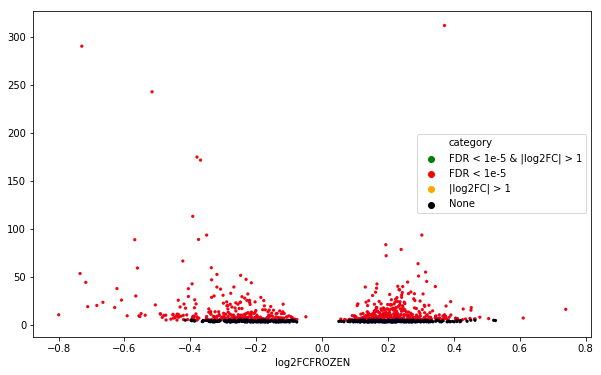

In [122]:
plt.figure(figsize=(10, 6))
plot_volcano(D4_FA3_nocontrol)

## integrate

In [123]:
deg_df = pd.concat(deg_dfs)
deg_min500_df = pd.concat(deg_min500_dfs)

In [124]:
deg_df_size = deg_df.groupby(['gene']).size().sort_values(ascending=False)
deg_min500_df_size = deg_min500_df.groupby(['gene']).size().sort_values(ascending=False)

In [125]:
deg_df_size[deg_df_size==3]

gene
PPP1R35    3
NME2       3
BLOC1S4    3
SH2B2      3
PLPPR3     3
SLC35D2    3
PAM16      3
GLRX5      3
dtype: int64

In [126]:
deg_df[deg_df['gene'].isin(
    deg_df_size[deg_df_size == 3].index.values)].sort_values(
        by=['gene', 'sample'])

,gene,FDR,log2FCFROZEN,sample
BLOC1S4,BLOC1S4,5.903293e-88,-1.382328,D1_FA2
BLOC1S4,BLOC1S4,2.215544e-109,-1.551311,D1_FA3
BLOC1S4,BLOC1S4,2.876368e-22,-1.050745,D4_FA2
GLRX5,GLRX5,6.677825e-316,-1.458636,D1_FA2
GLRX5,GLRX5,0.000000e+00,-1.603024,D1_FA3
GLRX5,GLRX5,4.878790e-97,-1.253032,D4_FA2
NME2,NME2,1.547946e-13,1.033563,D1_FA3
NME2,NME2,2.296790e-14,1.254655,D4_FA2
NME2,NME2,6.213619e-20,-1.082236,D4_FA3
PAM16,PAM16,4.623178e-12,1.314223,D1_FA3


In [127]:
print(deg_df.groupby(['sample'])['log2FCFROZEN'].agg(lambda x:sum(x>0)))
print(deg_df.groupby(['sample'])['log2FCFROZEN'].agg(lambda x:sum(x<0)))

sample
D1_FA2    12.0
D1_FA3    44.0
D4_FA2     5.0
D4_FA3     0.0
Name: log2FCFROZEN, dtype: float64
sample
D1_FA2    33.0
D1_FA3    29.0
D4_FA2    29.0
D4_FA3     7.0
Name: log2FCFROZEN, dtype: float64


In [128]:
deg_df.sort_values(by=['gene', 'sample']).to_csv("../results/deg_all_1e-5.tsv",
                                                 index=False,
                                                 sep='\t')

In [129]:
deg_min500_df_size[deg_min500_df_size==3]

gene
PPP1R35    3
GLRX5      3
dtype: int64

In [130]:
deg_min500_df[deg_min500_df['gene'].isin(
    deg_min500_df_size[deg_min500_df_size == 3].index.values)].sort_values(
        by=['gene', 'sample'])

,gene,FDR,log2FCFROZEN,sample
GLRX5,GLRX5,6.723493e-316,-1.457419,D1_FA2
GLRX5,GLRX5,0.000000e+00,-1.600576,D1_FA3
GLRX5,GLRX5,1.066685e-97,-1.254381,D4_FA2
PPP1R35,PPP1R35,1.499932e-76,-1.129992,D1_FA2
PPP1R35,PPP1R35,2.343765e-63,-1.012129,D1_FA3
PPP1R35,PPP1R35,6.657429e-65,-1.264587,D4_FA2


In [131]:
deg_min500_df.sort_values(by=['gene', 'sample']).to_csv("../results/deg_all_min500_1e-5.tsv",
                                                 index=False,
                                                 sep='\t')

In [132]:
print(deg_min500_df.groupby(['sample'])['log2FCFROZEN'].agg(lambda x:sum(x>0)))
print(deg_min500_df.groupby(['sample'])['log2FCFROZEN'].agg(lambda x:sum(x<0)))

sample
D1_FA2    2.0
D1_FA3    4.0
D4_FA2    0.0
Name: log2FCFROZEN, dtype: float64
sample
D1_FA2     8.0
D1_FA3     8.0
D4_FA2    14.0
Name: log2FCFROZEN, dtype: float64


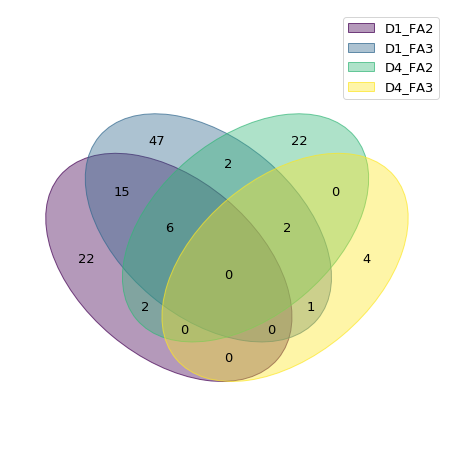

In [133]:
deg_df_venn = {
    'D1_FA2': set(deg_df[deg_df['sample'] == 'D1_FA2']['gene'].values),
    'D1_FA3': set(deg_df[deg_df['sample'] == 'D1_FA3']['gene'].values),
    'D4_FA2': set(deg_df[deg_df['sample'] == 'D4_FA2']['gene'].values),
    'D4_FA3': set(deg_df[deg_df['sample'] == 'D4_FA3']['gene'].values)
}
venn(deg_df_venn)

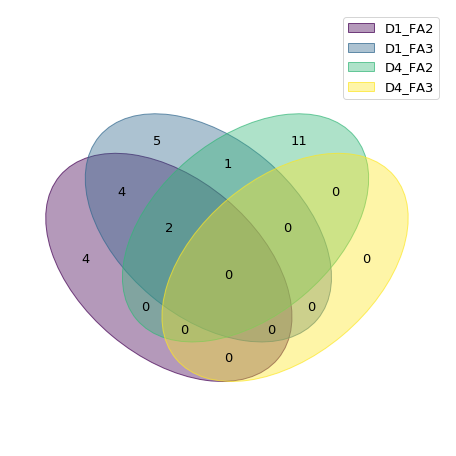

In [134]:
deg_min500_df_venn = {
    'D1_FA2': set(deg_min500_df[deg_min500_df['sample'] == 'D1_FA2']['gene'].values),
    'D1_FA3': set(deg_min500_df[deg_min500_df['sample'] == 'D1_FA3']['gene'].values),
    'D4_FA2': set(deg_min500_df[deg_min500_df['sample'] == 'D4_FA2']['gene'].values),
    'D4_FA3': set(deg_min500_df[deg_min500_df['sample'] == 'D4_FA3']['gene'].values)
}
venn(deg_min500_df_venn)

In [156]:
deg_all_df = pd.concat(deg_all_dfs)
deg_all_min500_df = pd.concat(deg_all_min500_dfs)

In [157]:
deg_all_df['gene'] = deg_all_df.index.values
deg_all_min500_df['gene'] = deg_all_min500_df.index.values

In [158]:
deg_all_df_size = deg_all_df.groupby(['gene'
                                      ]).size().sort_values(ascending=False)
deg_all_min500_df_size = deg_all_min500_df.groupby(
    ['gene']).size().sort_values(ascending=False)

In [180]:
deg_all_df.to_csv("../results/deg_all.tsv", sep="\t", index=False)

In [181]:
deg_all_df[deg_all_df['gene'].isin(
    deg_all_df[deg_all_df_size >=3]['gene'].values)].sort_values(
        by=['gene', 'sample']).to_csv("../results/deg_all_3common.tsv", sep="\t", index=False)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [182]:
deg_all_df[deg_all_df['gene'].isin(
    deg_all_df[deg_all_df_size >= 3]['gene'].values)].sort_values(
        by=['gene', 'sample']).drop_duplicates(subset=['gene']).to_csv(
            "../results/deg_all_3common_unique.tsv", sep="\t", index=False)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [183]:
deg_all_min500_df.to_csv("../results/deg_all_min500.tsv", sep="\t", index=False)

In [184]:
deg_all_min500_df[deg_all_min500_df['gene'].isin(deg_all_min500_df[
    deg_all_min500_df_size >= 3]['gene'].values)].sort_values(
        by=['gene', 'sample']).to_csv("../results/deg_all_min500_3common.tsv",
                                      sep="\t", index=False)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [185]:
deg_all_min500_df[deg_all_min500_df['gene'].isin(deg_all_min500_df[
    deg_all_min500_df_size >= 3]['gene'].values)].sort_values(
        by=['gene', 'sample']).drop_duplicates(subset=['gene']).to_csv(
            "../results/deg_all_min500_3common_unique.tsv", sep="\t", index=False)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# D1 vs D4 DEG comparison

## FA2

### all genes

In [18]:
DEG_fresh = pd.read_csv("../data/deg/D1D4_FRE_FA2_nocontrol.tsv", sep='\t')
DEG_frozen = pd.read_csv("../data/deg/D1D4_THA_FA2_nocontrol.tsv", sep='\t')

In [19]:
DEG_fresh = DEG_fresh[(DEG_fresh['FDR'] < 1e-3) & (np.abs(DEG_fresh['log2FCD4FA2FRESH'].values) > 1)]
DEG_frozen = DEG_frozen[(DEG_frozen['FDR'] < 1e-3) & (np.abs(DEG_frozen['log2FCD4FA2FROZEN'].values) > 1)]

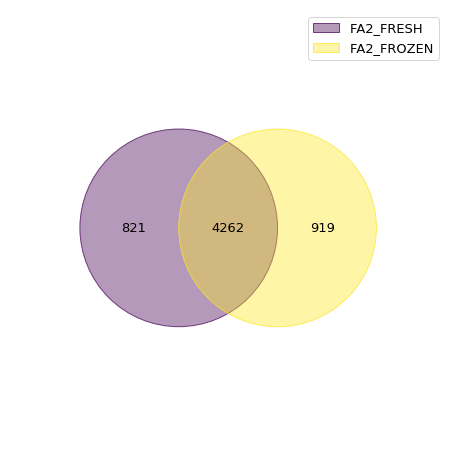

In [20]:
deg_df_venn = {
    'FA2_FRESH': set(DEG_fresh.index.values),
    'FA2_FROZEN': set(DEG_frozen.index.values)
}
venn(deg_df_venn)

### min 500

In [21]:
DEG_fresh = pd.read_csv("../data/deg/D1D4_FRE_FA2_min500_nocontrol.tsv", sep='\t')
DEG_frozen = pd.read_csv("../data/deg/D1D4_THA_FA2_min500_nocontrol.tsv", sep='\t')

In [22]:
DEG_fresh = DEG_fresh[(DEG_fresh['FDR'] < 1e-3) & (np.abs(DEG_fresh['log2FCD4FA2FRESH'].values) > 1)]
DEG_frozen = DEG_frozen[(DEG_frozen['FDR'] < 1e-3) & (np.abs(DEG_frozen['log2FCD4FA2FROZEN'].values) > 1)]

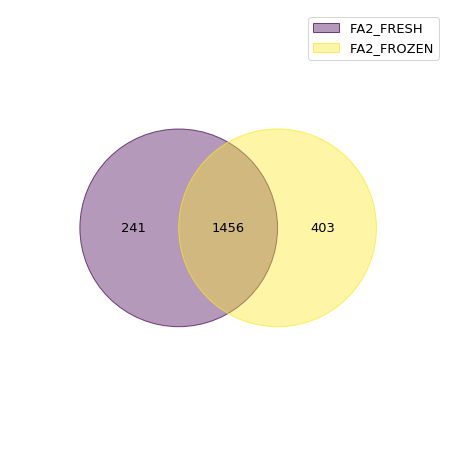

In [23]:
deg_df_venn = {
    'FA2_FRESH': set(DEG_fresh.index.values),
    'FA2_FROZEN': set(DEG_frozen.index.values)
}
venn(deg_df_venn)

## FA3

### all genes

In [24]:
DEG_fresh = pd.read_csv("../data/deg/D1D4_FRE_FA3_nocontrol.tsv", sep='\t')
DEG_frozen = pd.read_csv("../data/deg/D1D4_THA_FA3_nocontrol.tsv", sep='\t')

In [25]:
DEG_fresh = DEG_fresh[(DEG_fresh['FDR'] < 1e-3) & (np.abs(DEG_fresh['log2FCD4FA3FRESH'].values) > 1)]
DEG_frozen = DEG_frozen[(DEG_frozen['FDR'] < 1e-3) & (np.abs(DEG_frozen['log2FCD4FA3FROZEN'].values) > 1)]

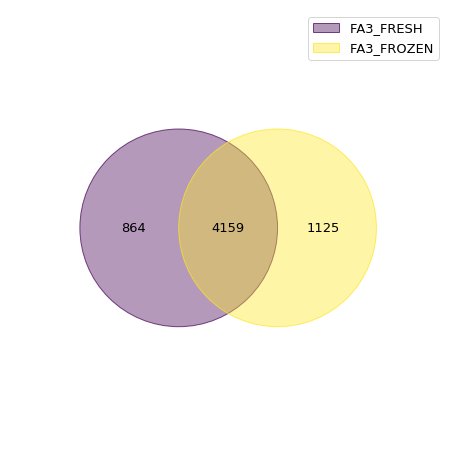

In [26]:
deg_df_venn = {
    'FA3_FRESH': set(DEG_fresh.index.values),
    'FA3_FROZEN': set(DEG_frozen.index.values)
}
venn(deg_df_venn)

### min 500

In [27]:
DEG_fresh = pd.read_csv("../data/deg/D1D4_FRE_FA3_min500_nocontrol.tsv", sep='\t')
DEG_frozen = pd.read_csv("../data/deg/D1D4_THA_FA3_min500_nocontrol.tsv", sep='\t')

In [28]:
DEG_fresh = DEG_fresh[(DEG_fresh['FDR'] < 1e-3) & (np.abs(DEG_fresh['log2FCD4FA3FRESH'].values) > 1)]
DEG_frozen = DEG_frozen[(DEG_frozen['FDR'] < 1e-3) & (np.abs(DEG_frozen['log2FCD4FA3FROZEN'].values) > 1)]

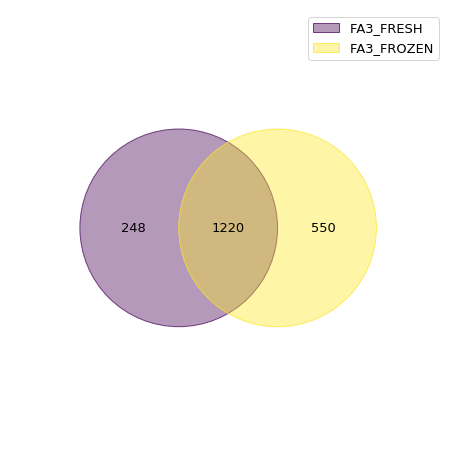

In [29]:
deg_df_venn = {
    'FA3_FRESH': set(DEG_fresh.index.values),
    'FA3_FROZEN': set(DEG_frozen.index.values)
}
venn(deg_df_venn)